<a href="https://colab.research.google.com/github/Gleibi/Cool_Project_Stock_Price_Prediction/blob/main/model_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install yfinance

# Выгрузка и подготовка данных

In [232]:
import yfinance as yf

In [233]:
aapl = yf.Ticker('AAPL')

hist = aapl.history(period='10y')

In [234]:
hist = hist.asfreq('D')
hist.fillna(method='bfill', inplace=True)

hist['close_shift'] =  hist.Close.shift(1)
hist['target'] = hist.Close - hist.close_shift

hist = hist[~hist.close_shift.isna()]

In [235]:
hist.isnull().values.any()

False

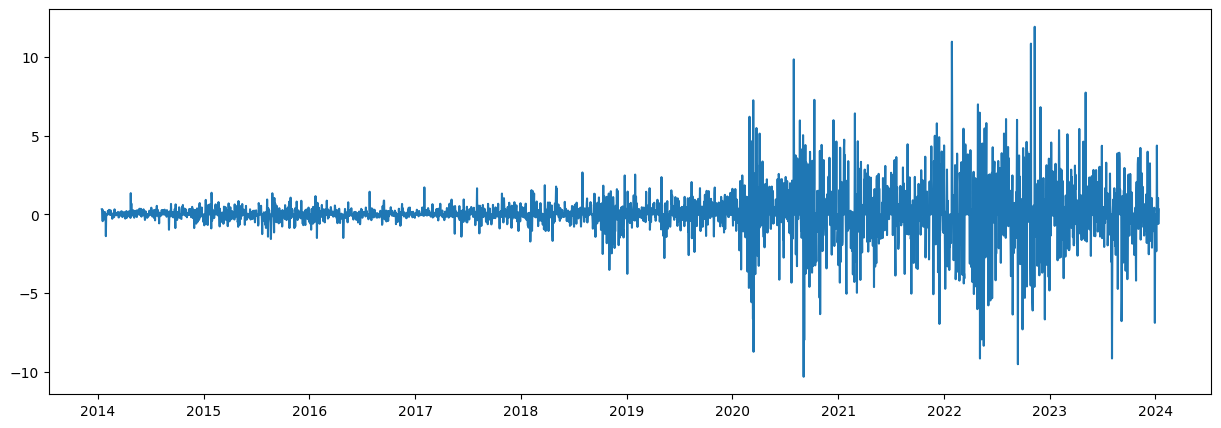

In [236]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(hist.target)
plt.show()

# Все нужные импорты

In [314]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.ensemble import GradientBoostingRegressor
from prophet import Prophet

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import ParameterGrid

from datetime import date, timedelta
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
import seaborn as sns

# Бейзлайн
Нужно выбрать то, с чем сравнивать модели. Возьмем константу, например, среднее изменение цены за прошлую неделю.

In [238]:
hist.reset_index(inplace=True)

hist['Date'] = hist.Date.dt.date

hist.set_index('Date', inplace=True)

In [239]:
start = date.today() - timedelta(days=7)

train = hist[hist.index <= start]
test = hist[hist.index > start]

In [240]:
y_train = train.target
y_test = test.target

In [241]:
results = dict()

y_pred = train[train.index >= date.today() - timedelta(days=14)].target.mean()

baseline = [y_pred for _ in range(y_test.shape[0])]

results['baseline'] = {
    'MAPE': round(mape(y_test, baseline), 3),
    'RMSE': round(mse(y_test, baseline, squared=True), 3),
    'MAE':  round(mae(y_test, baseline), 3),
}

In [242]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6}}

# Модели
## Простое экспоненциальное сглаживание

In [243]:
model = SimpleExpSmoothing(y_train).fit()

y_pred_ses = model.forecast(len(y_test))

results['ses'] = {
    'MAPE': round(mape(y_test, y_pred_ses), 3),
    'RMSE': round(mse(y_test, y_pred_ses, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_ses), 3),
}

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [244]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6}}

## Хольт

In [245]:
holt_params = {
  'exponential': False,
  'damped_trend': False
}

model = Holt(y_train, **holt_params).fit()

y_pred_holt = model.forecast(len(y_test))

results['holt'] = {
    'MAPE': round(mape(y_test, y_pred_holt), 3),
    'RMSE': round(mse(y_test, y_pred_holt, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_holt), 3),
}

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [246]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601}}

## Хольт-винтерс

In [247]:
hw_params = {
  'trend': 'add',
  'seasonal': 'add',
  'damped_trend': False
}

model = ExponentialSmoothing(y_train, **hw_params).fit()

y_pred_hw = model.forecast(len(y_test))

results['hw'] = {
    'MAPE': round(mape(y_test, y_pred_hw), 3),
    'RMSE': round(mse(y_test, y_pred_hw, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_hw), 3),
}

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [248]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583}}

## Prophet

In [249]:
args_prophet = {
    'weekly_seasonality': True,
    # 'yearly_seasonality': True,
    'daily_seasonality': True,
    # 'holidays_prior_scale': 2,
    'seasonality_mode': 'additive'
}

data_for_model = y_train.reset_index()
data_for_model.rename(columns={'Date':'ds', 'target': 'y'}, inplace=True)

model = Prophet(**args_prophet)
model.add_country_holidays(country_name='US')

model.fit(data_for_model)

future = model.make_future_dataframe(y_test.shape[0], freq='D', include_history = False)
forecast = model.predict(future)
y_pred_prophet = forecast.yhat

results['fbprophet'] = {
    'MAPE': round(mape(y_test, y_pred_prophet), 3),
    'RMSE': round(mse(y_test, y_pred_prophet, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_prophet), 3),
}

DEBUG:cmdstanpy:input tempfile: /tmp/tmpau30pcp0/65kva_9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpau30pcp0/_n36cvg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75864', 'data', 'file=/tmp/tmpau30pcp0/65kva_9r.json', 'init=/tmp/tmpau30pcp0/_n36cvg9.json', 'output', 'file=/tmp/tmpau30pcp0/prophet_modelmtp7__r6/prophet_model-20240115214443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [250]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583},
 'fbprophet': {'MAPE': 0.97, 'RMSE': 0.408, 'MAE': 0.58}}

## Gradient Boosting

In [290]:
def create_time_feature(df):

    df['dayofmonth'] = df['Date'].dt.day.apply(str)
    df['dayofweek'] = df['Date'].dt.dayofweek.apply(str)
    df['quarter'] = df['Date'].dt.quarter.apply(str)
    df['month'] = df['Date'].dt.month.apply(str)
    df['year'] = df['Date'].dt.year.apply(str)
    df['dayofyear'] = df['Date'].dt.dayofyear.apply(str)
    df['weekofyear'] = df['Date'].dt.isocalendar().week.apply(str)

    return df

In [291]:
df_gb_features = hist.copy()

for w in [3, 5, 10, 30]:
  df_gb_features[f'rolling_{w}'] = df_gb_features.target.rolling(window=w).mean().shift(1)

start_date = df_gb_features.index.min() + timedelta(days=30) # чтобы не было пропусков в новых фичах

df_gb_features = df_gb_features[df_gb_features.index > start_date]

df_gb_features.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,target,rolling_3,rolling_5,rolling_10,rolling_30
Date,,,,,,,,,,,,,
2014-02-14,17.086626,17.197185,17.046941,17.134502,272924400.0,0.0,0.0,17.148363,-0.013861,0.162111,0.097267,0.144526,0.001356
2014-02-15,17.197817,17.361290,17.185532,17.197502,260251600.0,0.0,0.0,17.134502,0.063000,0.084307,0.094495,0.120408,-0.010556
2014-02-16,17.197817,17.361290,17.185532,17.197502,260251600.0,0.0,0.0,17.197502,0.000000,0.105728,0.107095,0.114810,-0.005210
2014-02-17,17.197817,17.361290,17.185532,17.197502,260251600.0,0.0,0.0,17.197502,0.000000,0.016380,0.063184,0.105455,0.008963
2014-02-18,17.197817,17.361290,17.185532,17.197502,260251600.0,0.0,0.0,17.197502,0.000000,0.021000,0.063437,0.082871,0.000197


In [292]:
# Samsung
smsn = yf.Ticker('005930.KS')

samsung_hist = smsn.history('10y')

# SONY
sony = yf.Ticker('SONY')

sony_hist = sony.history('10y')

# Xiaomi
xiaomi = yf.Ticker('1810.HK')

xiaomi_hist = xiaomi.history('10y')

In [293]:
def normalize_hist(hist, col_name):

  hist = hist.asfreq('D')
  hist.fillna(method='bfill', inplace=True)

  hist['close_shift'] =  hist.Close.shift(2)
  hist[f'{col_name}_target'] = hist.Close - hist.close_shift

  hist = hist[~hist.close_shift.isna()]

  hist.reset_index(inplace=True)

  hist['Date'] = hist.Date.dt.date

  hist.set_index('Date', inplace=True)

  return hist

samsung_hist = normalize_hist(samsung_hist, 'samsung')
sony_hist = normalize_hist(sony_hist, 'sony')
xiaomi_hist = normalize_hist(xiaomi_hist, 'xiaomi')

samsung_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,samsung_target
Date,,,,,,,,,
2014-01-17,20785.425210,21009.096196,20641.636719,20641.636719,12774250.0,0.0,0.0,20753.472656,-111.835938
2014-01-18,20849.334654,21073.005677,20705.546139,21025.076172,8682800.0,0.0,0.0,20785.427734,239.648438
2014-01-19,20849.334654,21073.005677,20705.546139,21025.076172,8682800.0,0.0,0.0,20641.636719,383.439453
2014-01-20,20849.334654,21073.005677,20705.546139,21025.076172,8682800.0,0.0,0.0,21025.076172,0.000000
2014-01-21,21009.100154,21200.818178,20945.194146,21152.888672,7562300.0,0.0,0.0,21025.076172,127.812500


In [294]:
df_gb_features['samsung_target'] = samsung_hist.samsung_target
df_gb_features['sony_target'] = sony_hist.sony_target
df_gb_features['xiaomi_target'] = xiaomi_hist.xiaomi_target
df_gb_features.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,target,rolling_3,rolling_5,rolling_10,rolling_30,samsung_target,sony_target,xiaomi_target
Date,,,,,,,,,,,,,,,,
2014-02-14,17.086626,17.197185,17.046941,17.134502,272924400.0,0.0,0.0,17.148363,-0.013861,0.162111,0.097267,0.144526,0.001356,-95.851562,-0.260000,NaN
2014-02-15,17.197817,17.361290,17.185532,17.197502,260251600.0,0.0,0.0,17.134502,0.063000,0.084307,0.094495,0.120408,-0.010556,-207.691406,0.139999,NaN
2014-02-16,17.197817,17.361290,17.185532,17.197502,260251600.0,0.0,0.0,17.197502,0.000000,0.105728,0.107095,0.114810,-0.005210,-255.619141,0.280001,NaN
2014-02-17,17.197817,17.361290,17.185532,17.197502,260251600.0,0.0,0.0,17.197502,0.000000,0.016380,0.063184,0.105455,0.008963,0.000000,0.000000,NaN
2014-02-18,17.197817,17.361290,17.185532,17.197502,260251600.0,0.0,0.0,17.197502,0.000000,0.021000,0.063437,0.082871,0.000197,159.763672,0.000000,NaN


In [295]:
df_gb_features = df_gb_features.reset_index()

df_gb_features.Date = pd.to_datetime(df_gb_features.Date)

df_gb_features = create_time_feature(df_gb_features)

In [296]:
df_gb_features = df_gb_features[~df_gb_features.xiaomi_target.isna()]

In [297]:
df_gb_features.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,target,...,samsung_target,sony_target,xiaomi_target,dayofmonth,dayofweek,quarter,month,year,dayofyear,weekofyear
1608,2018-07-11,44.916293,45.221294,44.704221,44.768559,75326000.0,0.0,0.0,45.357124,-0.588566,...,346.285156,0.349998,2.200001,11,2,3,7,2018,192,28
1609,2018-07-12,45.161718,45.609691,45.109296,45.519142,72164400.0,0.0,0.0,44.768559,0.750584,...,-692.582031,0.529999,0.260000,12,3,3,7,2018,193,28
1610,2018-07-13,45.531059,45.712152,45.488166,45.590630,50055600.0,0.0,0.0,45.519142,0.071487,...,432.855469,1.350002,2.450001,13,4,3,7,2018,194,28
1611,2018-07-14,45.635904,45.905161,45.373791,45.490551,60172400.0,0.0,0.0,45.590630,-0.100079,...,476.152344,1.060001,1.789999,14,5,3,7,2018,195,28
1612,2018-07-15,45.635904,45.905161,45.373791,45.490551,60172400.0,0.0,0.0,45.490551,0.000000,...,-389.566406,-0.040001,-0.400002,15,6,3,7,2018,196,28


In [299]:
cols = ['Open', 'High', 'Low', 'Close']

for col in cols:
  df_gb_features[f'{col}_prev'] = df_gb_features[col].shift(1)
  # df_gb_features[f'{col}_prev_week'] = df_gb_features[col].shift(7)
  # df_gb_features[f'{col}_prev_month'] = df_gb_features[col].shift(30)


df_gb_features = df_gb_features[~df_gb_features['Open_prev'].isna()]

In [300]:
from sklearn.preprocessing import StandardScaler

# cols = ['rolling_3', 'rolling_5',
#        'rolling_10', 'rolling_30', 'samsung_target', 'sony_target',
#        'xiaomi_target', 'Open_prev', 'Open_prev_week',
#        'Open_prev_month', 'High_prev', 'High_prev_week', 'High_prev_month',
#        'Low_prev', 'Low_prev_week', 'Low_prev_month', 'Close_prev',
#        'Close_prev_week', 'Close_prev_month']
cols = ['target', 'rolling_3', 'rolling_5',
       'rolling_10', 'rolling_30', 'samsung_target', 'sony_target',
       'xiaomi_target', 'dayofmonth', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'weekofyear', 'Open_prev', 'High_prev',
       'Low_prev', 'Close_prev']

scaler = StandardScaler()

scaler.fit(df_gb_features[cols])
df_gb_features[cols] = scaler.transform(df_gb_features[cols])
df_gb_features.head()

<ipython-input-300-af902a10ec8a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gb_features[cols] = scaler.transform(df_gb_features[cols])


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_shift,target,...,dayofweek,quarter,month,year,dayofyear,weekofyear,Open_prev,High_prev,Low_prev,Close_prev
1609,2018-07-12,45.161718,45.609691,45.109296,45.519142,72164400.0,0.0,0.0,44.768559,0.358982,...,-0.000249,0.368455,0.069335,-1.71604,0.025511,0.025423,-1.426827,-1.434411,-1.419100,-1.431634
1610,2018-07-13,45.531059,45.712152,45.488166,45.590630,50055600.0,0.0,0.0,45.519142,0.000685,...,0.499969,0.368455,0.069335,-1.71604,0.034946,0.025423,-1.421861,-1.426625,-1.410832,-1.416462
1611,2018-07-14,45.635904,45.905161,45.373791,45.490551,60172400.0,0.0,0.0,45.590630,-0.089835,...,1.000187,0.368455,0.069335,-1.71604,0.044382,0.025423,-1.414386,-1.424571,-1.403098,-1.415017
1612,2018-07-15,45.635904,45.905161,45.373791,45.490551,60172400.0,0.0,0.0,45.490551,-0.037033,...,1.500404,0.368455,0.069335,-1.71604,0.053818,0.025423,-1.412264,-1.420702,-1.405433,-1.417040
1613,2018-07-16,45.635904,45.905161,45.373791,45.490551,60172400.0,0.0,0.0,45.490551,-0.037033,...,-1.500902,0.368455,0.069335,-1.71604,0.063253,0.091477,-1.412264,-1.420702,-1.405433,-1.417040


In [301]:
start = date.today() - timedelta(days=7)

cols = ['target', 'rolling_3', 'rolling_5',
       'rolling_10', 'rolling_30', 'samsung_target', 'sony_target',
       'xiaomi_target', 'dayofmonth', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'weekofyear', 'Open_prev', 'High_prev',
       'Low_prev', 'Close_prev']

df_gb_features.Date = df_gb_features.Date.dt.date

df_train = df_gb_features[df_gb_features.Date <= start][cols]
y_train = df_train.target

df_train.drop(columns='target', inplace=True)

df_test = df_gb_features[df_gb_features.Date > start][cols]
y_test = df_test.target

df_test.drop(columns='target', inplace=True)

gb_params = {
    'n_estimators': 10000,
    'loss': 'squared_error',
    'learning_rate': 0.05,
    'random_state': 12,
    'verbose': 1,
    'n_iter_no_change': 100
}

model = GradientBoostingRegressor(**gb_params)
model.fit(df_train, y_train)

<ipython-input-301-cf1afed59931>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gb_features.Date = df_gb_features.Date.dt.date


      Iter       Train Loss   Remaining Time 
         1           0.9725            1.69m
         2           0.9591            1.75m
         3           0.9461            1.75m
         4           0.9342            1.90m
         5           0.9234            1.91m
         6           0.9123            1.90m
         7           0.9032            1.90m
         8           0.8949            1.89m
         9           0.8858            1.94m
        10           0.8788            1.92m
        20           0.8186            1.88m
        30           0.7795            1.86m
        40           0.7522            1.84m
        50           0.7295            1.81m
        60           0.7092            1.78m
        70           0.6918            1.77m
        80           0.6758            1.75m
        90           0.6611            1.75m
       100           0.6478            1.74m
       200           0.5340            1.69m


GradientBoostingRegressor(learning_rate=0.05, n_estimators=10000,
                          n_iter_no_change=100, random_state=12, verbose=1)

In [302]:
y_pred_gb = model.predict(df_test)

In [303]:
results['gradient_boosting'] = {
    'MAPE': round(mape(y_test, y_pred_gb), 3),
    'RMSE': round(mse(y_test, y_pred_gb, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_gb), 3),
}

In [304]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583},
 'fbprophet': {'MAPE': 0.97, 'RMSE': 0.408, 'MAE': 0.58},
 'gradient_boosting': {'MAPE': 1.685, 'RMSE': 0.311, 'MAE': 0.4}}

## Линейная регрессия

In [305]:
model = LinearRegression()
model.fit(df_train, y_train)

LinearRegression()

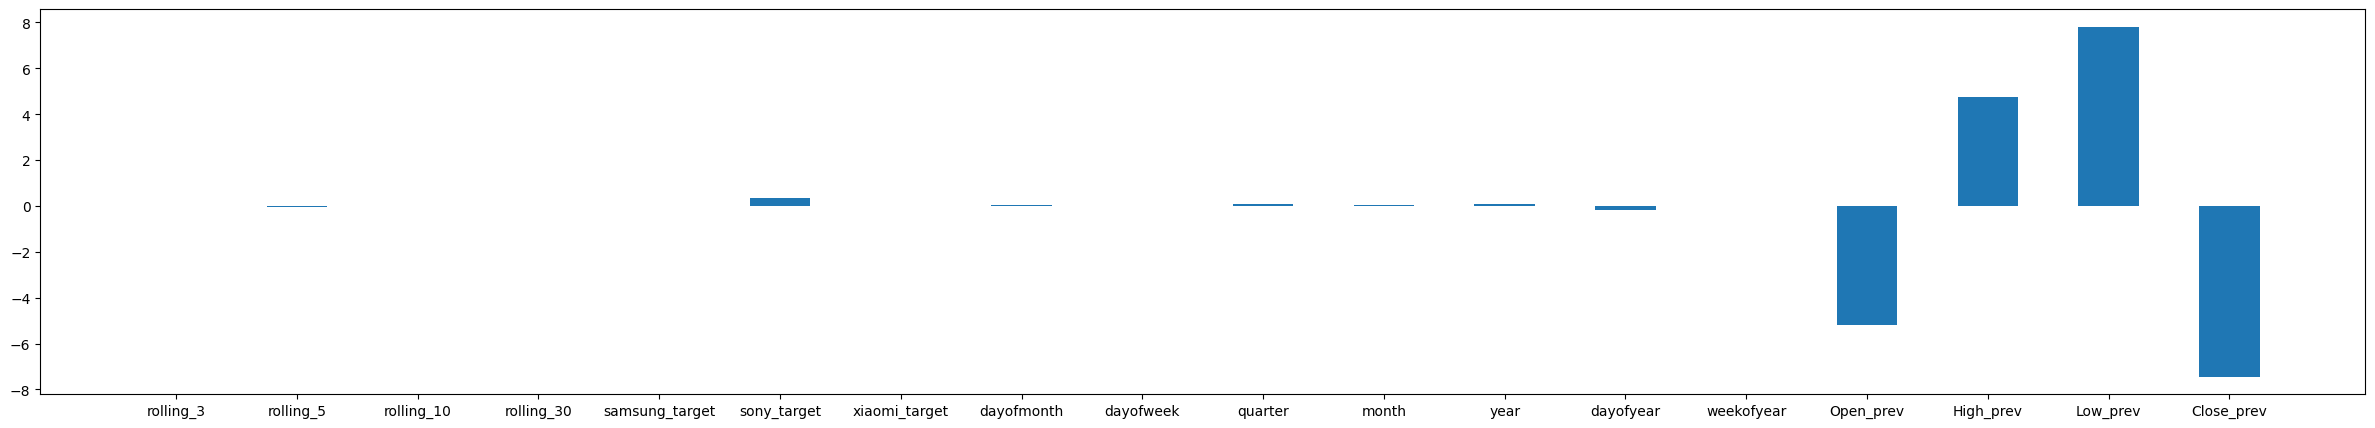

In [307]:
plt.figure(figsize=(30, 5))
plt.bar(x=df_train.columns, height=model.coef_, width=.5)
plt.show()

<Axes: >

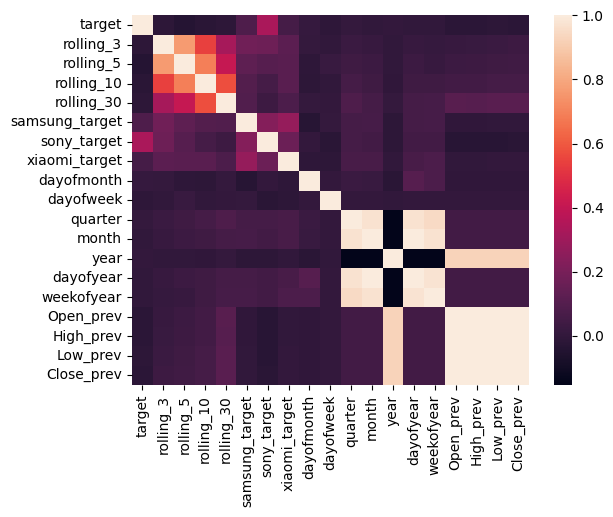

In [308]:
sns.heatmap(df_gb_features[cols].corr())

<ipython-input-288-944a1f5bda24>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_gb_features[cols].corr())


<Axes: >

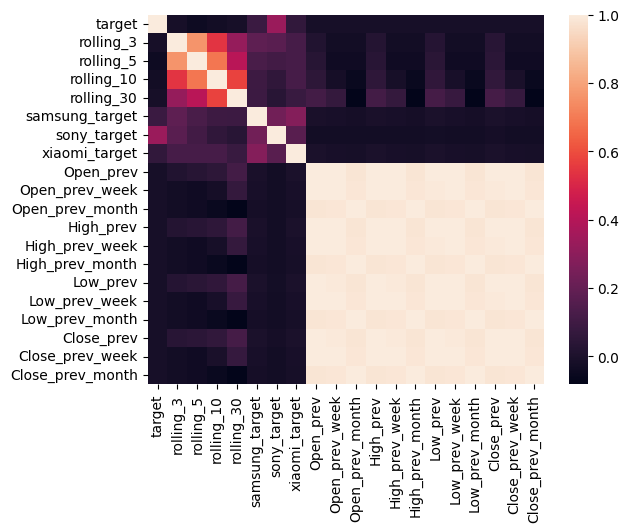

In [288]:
sns.heatmap(df_gb_features[cols].corr())

In [320]:
cols = ['rolling_3', 'rolling_30', 'samsung_target', 'sony_target',
       'xiaomi_target', 'Close_prev']

model = LinearRegression()
model.fit(df_train[cols], y_train)

LinearRegression()

In [321]:
y_pred_lr = model.predict(df_test[cols])

In [322]:
results['linear_regression'] = {
    'MAPE': round(mape(y_test, y_pred_lr), 3),
    'RMSE': round(mse(y_test, y_pred_lr, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_lr), 3),
}

In [323]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583},
 'fbprophet': {'MAPE': 0.97, 'RMSE': 0.408, 'MAE': 0.58},
 'gradient_boosting': {'MAPE': 1.685, 'RMSE': 0.311, 'MAE': 0.4},
 'linear_regression': {'MAPE': 2.148, 'RMSE': 0.546, 'MAE': 0.544}}

In [324]:
model = Ridge()
model.fit(df_train[cols], y_train)

Ridge()

In [325]:
y_pred_lr_ridge = model.predict(df_test[cols])

In [326]:
results['ridge'] = {
    'MAPE': round(mape(y_test, y_pred_lr_ridge), 3),
    'RMSE': round(mse(y_test, y_pred_lr_ridge, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_lr_ridge), 3),
}

In [327]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583},
 'fbprophet': {'MAPE': 0.97, 'RMSE': 0.408, 'MAE': 0.58},
 'gradient_boosting': {'MAPE': 1.685, 'RMSE': 0.311, 'MAE': 0.4},
 'linear_regression': {'MAPE': 2.148, 'RMSE': 0.546, 'MAE': 0.544},
 'ridge': {'MAPE': 2.147, 'RMSE': 0.545, 'MAE': 0.544}}

In [328]:
model = Lasso()
model.fit(df_train[cols], y_train)

Lasso()

In [329]:
y_pred_lr_lasso = model.predict(df_test[cols])

results['lasso'] = {
    'MAPE': round(mape(y_test, y_pred_lr_lasso), 3),
    'RMSE': round(mse(y_test, y_pred_lr_lasso, squared=True), 3),
    'MAE':  round(mae(y_test, y_pred_lr_lasso), 3),
}

In [330]:
results

{'baseline': {'MAPE': 1.0, 'RMSE': 0.439, 'MAE': 0.6},
 'ses': {'MAPE': 1.001, 'RMSE': 0.43, 'MAE': 0.6},
 'holt': {'MAPE': 1.002, 'RMSE': 0.439, 'MAE': 0.601},
 'hw': {'MAPE': 0.992, 'RMSE': 0.401, 'MAE': 0.583},
 'fbprophet': {'MAPE': 0.97, 'RMSE': 0.408, 'MAE': 0.58},
 'gradient_boosting': {'MAPE': 1.685, 'RMSE': 0.311, 'MAE': 0.4},
 'linear_regression': {'MAPE': 2.148, 'RMSE': 0.546, 'MAE': 0.544},
 'ridge': {'MAPE': 2.147, 'RMSE': 0.545, 'MAE': 0.544},
 'lasso': {'MAPE': 1.0, 'RMSE': 0.119, 'MAE': 0.317}}

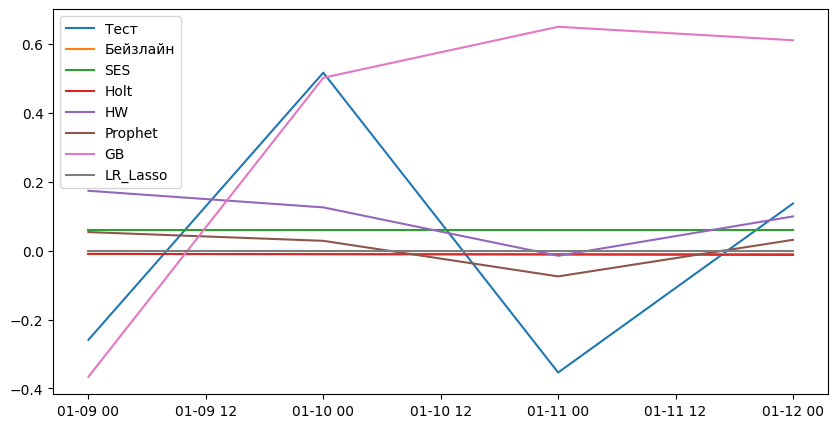

In [348]:
legend = ['Тест', 'Бейзлайн', 'SES', 'Holt', 'HW', 'Prophet', 'GB', 'LR_Lasso']

plt.figure(figsize=(10, 5))

plt.plot(test.index, y_test)
plt.plot(test.index, baseline)
plt.plot(test.index, y_pred_ses)
plt.plot(test.index, y_pred_holt)
plt.plot(test.index, y_pred_hw)
plt.plot(test.index, y_pred_prophet)
plt.plot(test.index, y_pred_gb)
# plt.plot(test.index, y_pred_lr)
# plt.plot(test.index, y_pred_lr_ridge)
plt.plot(test.index, y_pred_lr_lasso)

plt.legend(legend)